In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2
from sklearn.model_selection import train_test_split
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

### A Recursive Feature Elimination (RFE) model with automatic tuning of the number of features selected with cross-validation.

In [2]:
target = 'NEE'

In [3]:
# loads all data sets into a dict
def load_datasets(dirs: list) -> dict:
    files = ['soil_c','surf_water','soil_temp','flux_soc','soil_water','n_flux','p_flux','temp', 
         'plant_c','plant_n','plant_p','canopcy_c','canopy_temp','plant_stress','photosynthesis','plant_growth']
    
    datasets = {}
    
    for dr in dirs:
        csv_list = []
        path = 'datasets/' + dr + '/daily_data_merged'
        for f in files:
            df = pd.read_csv(os.path.join(path,f + '.csv'))
            df.drop(df.columns[0], axis=1)

            csv_list.append(df)


        data_dict = {}
        for i in range (len(csv_list)):
            data_dict[files[i]] = csv_list[i]

        datasets[dr] = data_dict

    return datasets

dirs = ['warm_temp_maize_soybean_irrigated', 'warm_temp_maize-soybean_dryland', 'cool_temp_maize_soybean']

datasets = load_datasets(dirs)

In [4]:
def rename_dupes(suffix: str, df: pd.DataFrame, dupes: list) -> pd.DataFrame:
    for col in df.columns:
        if col in dupes:
            df.rename(columns={col: col + suffix}, inplace=True)
    return df

def average_numbered_columns(df):
    numbered_cols = [col for col in df.columns if '_' in col and col.split('_')[-1].isdigit()]

    col_groups = {}
    for col in numbered_cols:
        prefix = '_'.join(col.split('_')[:-1])
        if prefix not in col_groups:
            col_groups[prefix] = []
        col_groups[prefix].append(col)

    # calculate averages and add new columns
    for prefix, cols in col_groups.items():
        avg_col_name = prefix
        avg_col_values = df[cols].mean(axis=1)
        df[avg_col_name] = avg_col_values

    # drop numbered columns
    df = df.drop(columns=numbered_cols)

    return df

# turn all csv's to one dataframe
def to_pd(df: dict, handle_dupes: bool, flatten_num_cols: bool) -> pd.DataFrame:
    x = pd.DataFrame()
    for file_name in df:
        cur = df[file_name]
            
        x = pd.concat([x, df[file_name]], axis = 1)
        
    cheeky_col = 'unnamed.1'
    cheeky_col2 = 'Unnamed: 0'
    if cheeky_col in x.columns:
        x = x.drop([cheeky_col], axis=1)
    elif cheeky_col2 in x.columns:
         x = x.drop([cheeky_col2], axis=1)
    x = x.drop(['DATE'], axis=1)

    if flatten_num_cols:
        x = average_numbered_columns(x)
        
    x = x.loc[:,~x.columns.duplicated()].copy()
    
    one_hot = pd.get_dummies(x['GROWTH_STG'])
    x= x.drop('GROWTH_STG',axis = 1)
    # Join the encoded df
    x = x.join(one_hot)

    x.columns = x.columns.str.translate("".maketrans({"[":"{", "]":"}","<":"^"}))
    
    return x

df_dry = to_pd(datasets['warm_temp_maize-soybean_dryland'], True, False)
df_irr = to_pd(datasets['warm_temp_maize_soybean_irrigated'], True, False)
df_cool = to_pd(datasets['cool_temp_maize_soybean'], True, True)

df_dry['NEE'] = df_dry['ECO_GPP'] - df_dry['ECO_RH']
df_irr['NEE'] = df_irr['ECO_GPP'] - df_irr['ECO_RH']
#df_cool['NEE'] = df_cool['ECO_GPP'] - df_cool['ECO_RH']
df= pd.concat([df_dry, df_irr])
df.dropna(inplace=True)
y = df[target]
df = df.drop(target, axis=1)

In [111]:
xgbFeatImp = pd.read_csv('feature_analysis/xgboost/FeaturesImportance' + target + '.csv')

In [112]:
xgbFeatImp

,Unnamed: 0,GINI
0,CAN_RA,0.728495
1,D_NH3_FLUX,0.133169
2,D_AUTO_RESP,0.087249
3,ABV_GRD_RESP,0.028407
4,SHOOT_P,0.003498
...,...,...
56,CAN_CO2_FLUX,0.000013
57,MIN_LWP,0.000013
58,NO3,0.000012
59,WTR_STRESS,0.000011


In [ ]:
feat_cols = []
for i in range(len(xgbFeatImp.values)):
    feat_cols.append(xgbFeatImp.values[i][0])

y = df[target].copy()
x = df[feat_cols]

X_train, X_test, y_train, y_test = train_test_split(
   x, y, test_size=0.33, random_state=41)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
   df, y, test_size=0.33, random_state=41)

RANDOM FOREST

In [ ]:
min_features_to_select = 1  # Minimum number of features to consider

cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)
clf = RandomForestRegressor(criterion = "absolute_error", random_state =1)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="neg_mean_squared_error",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(X_train, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")

RIDGE REG

In [ ]:
min_features_to_select = 1  # Minimum number of features to consider

lmbdas = [i/2 for i in range(1,50)]
cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)
clf = RidgeCV(alphas=lmbdas, cv=cv, scoring='neg_mean_squared_error')

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="neg_mean_squared_error",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(X_train, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")

XGBOOST

In [28]:
min_features_to_select = 1  # Minimum number of features to consider

cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)
clf = xg.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 123)

param_grid = {'max_depth': [3, 4, 5, 6, 7],
              'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
              'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
              'colsample_bylevel':[0.6,0.7,0.8,0.9,1.0],
             'min_child_weight': [1, 5, 10],
             'gamma': [0.5, 1, 1.5, 2, 5],}

grid_search = GridSearchCV(estimator=xg, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=4, cv=cv, verbose=0)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="neg_mean_squared_error",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)

rfecv.fit(X_train, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 11


In [29]:
base_estimator = str(rfecv.estimator).split('(')[0]


path_to_save = 'feature_analysis/' + 'rcef_'+ base_estimator
os.makedirs(path_to_save , exist_ok=True)  

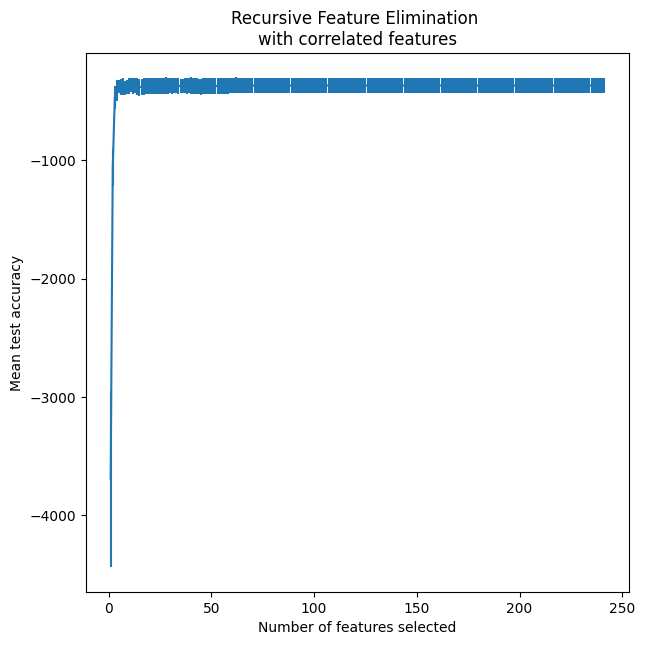

In [30]:
n_scores = len(rfecv.cv_results_["mean_test_score"])
fig = plt.figure(figsize=(7,7))
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()


base_estimator = str(rfecv.estimator).split('(')[0]

In [31]:
fig.savefig(os.path.join(path_to_save, target + '_' + base_estimator ), format='png')

In [32]:
importances = pd.DataFrame({'RANK': rfecv.ranking_}, index=rfecv.feature_names_in_).sort_values(by='RANK', ascending=True)

In [33]:
importances=importances[importances['RANK'] == 1]

In [34]:
importances

,RANK
HUSK_N,1
NH3_FLUX,1
N2_FLUX,1
EXUD_C,1
SHOOT_N,1
ECO_RH,1
STALK_N,1
STORED_N,1
D_TRANSPN,1
LITTER_N,1


In [35]:
importances.to_csv('feature_analysis/' + 'rcef_' + base_estimator + '/FeaturesImportances' + target + '.csv')  

In [36]:
pred = rfecv.predict(X_test)

RMSE :  19.027110


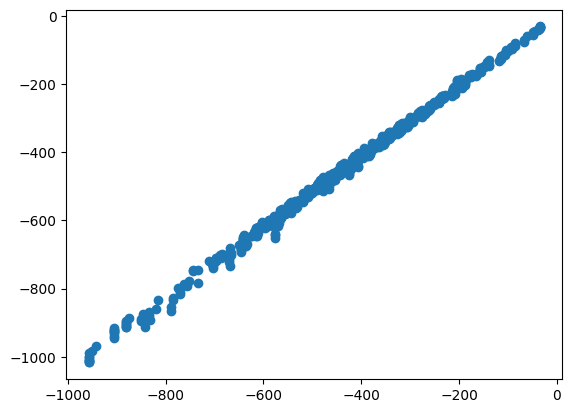

In [37]:
# RMSE Computation
rmse = np.sqrt(MSE(pred, y_test))
print("RMSE : % f" %(rmse))
plt.scatter(pred, y_test)

R2 :  0.990362


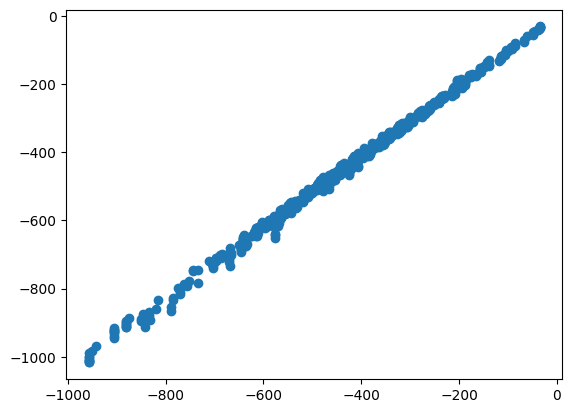

In [38]:
# RMSE Computation
r2 = (R2(pred, y_test))
print("R2 : % f" %(r2))
plt.scatter(pred, y_test)

In [ ]:
x_cool = to_pd(datasets['cool_temp_maize_soybean'], True, True)
y_cool = x_cool[target].copy()
x_cool = x_cool.drop(target,axis = 1)

In [26]:
importances.values

array([[1],
       [1],
       [1]])

In [32]:
xgbFeatImp = pd.read_csv('feature_analysis/rcef_' +base_estimator + '/FeaturesImportances' + target + '.csv')

feat_cols = []
for i in range(len(xgbFeatImp.values)):
    feat_cols.append(xgbFeatImp.values[i][0])

In [33]:
x_cool = x_cool[feat_cols]

In [35]:
x_cool

,STORED_N,CAN_HT,NODE_NO.
0,0.0,0.0,NaN
1,0.0,0.0,NaN
2,0.0,0.0,NaN
3,0.0,0.0,NaN
4,0.0,0.0,NaN
...,...,...,...
2552,0.0,0.0,NaN
2553,0.0,0.0,NaN
2554,0.0,0.0,NaN
2555,0.0,0.0,NaN


In [34]:
pred_col = rfecv.predict(x_cool)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- AUTO_RESP
- CAN_CO2_FLUX
- CAN_LE
- CAN_RA
- CH4_FLUX
- ...


In [ ]:
# RMSE Computation
rmse = np.sqrt(MSE(y_cool, pred_col))
print("RMSE : % f" %(rmse))
plt.scatter(pred_col, y_dry)

In [ ]:
for i in range(x.shape[1]):
 print('Column: %s, Selected %s, Rank: %.3f' % (rfecv.feature_names_in_[i], rfecv.support_[i], rfecv.ranking_[i]))